# Обучение модели Segformer для сегментации повреждений автомобиля

 - Установка и импорт библиотек

In [ ]:
!pip install transformers datasets torchvision evaluate accelerate

In [ ]:
!pip install segmentation-models-pytorch

In [29]:
from datasets import DatasetDict, Dataset
from transformers import SegformerForSemanticSegmentation
from transformers import TrainingArguments, Trainer
import os
from tqdm import tqdm
from PIL import Image
from transformers import SegformerImageProcessor
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 - Создание датасета

In [ ]:
def get_image_mask_pairs(image_dir, mask_dir):
    data = []
    for fname in tqdm(os.listdir(image_dir)):
        if fname.endswith(".jpg") or fname.endswith(".png"):
            img_path = os.path.join(image_dir, fname)
            mask_path = os.path.join(mask_dir, fname.replace(".jpg", ".png"))
            if os.path.exists(mask_path):
                data.append({"image_path": img_path, "mask_path": mask_path})
    return data

dataset = DatasetDict({
    "train": Dataset.from_list(get_image_mask_pairs("/kaggle/input/car-damage-segm/car-damage-detection-1/train", "/kaggle/input/car-damage-segm/car-damage-detection-1/train_masks")),
    "val": Dataset.from_list(get_image_mask_pairs("/kaggle/input/car-damage-segm/car-damage-detection-1/valid", "/kaggle/input/car-damage-segm/car-damage-detection-1/valid_masks")),
    "test": Dataset.from_list(get_image_mask_pairs("/kaggle/input/car-damage-segm/car-damage-detection-1/test", "/kaggle/input/car-damage-segm/car-damage-detection-1/test_masks"))
})

100%|██████████| 227/227 [00:00<00:00, 1796.80it/s]


In [2]:
dataset = DatasetDict({
    "train": dataset['train'],
    "val": dataset['val'],
    "test": dataset["test"]
})


In [ ]:
processor = SegformerImageProcessor(do_reduce_labels=False, size=640)

2025-05-18 17:03:30.613519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747587810.636408      98 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747587810.643395      98 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Аугментации

 - Сделаем небольшие аугментации

In [ ]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussianBlur(p=0.1),
])

def transform_aug(batch):
    pixel_values = []
    labels = []

    for img_path, mask_path in zip(batch["image_path"], batch["mask_path"]):
        try:
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))

            augmented = train_aug(image=image, mask=mask)
            image_aug = augmented["image"]
            mask_aug = augmented["mask"]

            processed = processor(images=image_aug, segmentation_maps=mask_aug, return_tensors="pt")

            pixel_values.append(processed["pixel_values"].squeeze(0).numpy().astype(np.float32))
            labels.append(processed["labels"].squeeze(0).numpy().astype(np.uint8))

        except Exception as e:
            print(f"Ошибка с {img_path}: {e}")
            continue

    return {"pixel_values": pixel_values, "labels": labels}


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
dataset["train"] = dataset["train"].map(transform_aug, batched=True, batch_size=4)

In [ ]:
def transform_no_aug(batch):
    pixel_values = []
    labels = []

    for img_path, mask_path in zip(batch["image_path"], batch["mask_path"]):
        try:
            # image = np.array(Image.open(img_path).convert("RGB").resize((512, 512)))
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))

            processed = processor(images=image, segmentation_maps=mask, return_tensors="pt")

            pixel_values.append(processed["pixel_values"].squeeze(0).numpy().astype(np.float32))
            labels.append(processed["labels"].squeeze(0).numpy().astype(np.uint8))

        except Exception as e:
            print(f"Ошибка с {img_path}: {e}")
            continue

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
dataset["val"] = dataset["val"].map(transform_no_aug, batched=True, batch_size=4)
dataset["test"] = dataset["test"].map(transform_no_aug, batched=True, batch_size=4)


## Процесс обучения модели

 - Будем использовать предобученную модель segformer-b2

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    num_labels=2,
    id2label={0: "background", 1: "damage"},
    label2id={"background": 0, "damage": 1},
    ignore_mismatched_sizes=True
)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используем следующие метрики:
 - damage_iou - отвечает за сегментацию повреждений (ключевая метрика)
 - background_iou - сегментация фона
 - mean_iou
 - accuracy

In [ ]:
args = TrainingArguments(
    output_dir="./segformer-damage",
    eval_strategy="steps",
    eval_steps=250,
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=7,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    report_to=[]
)

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=1)

    labels = torch.tensor(labels).unsqueeze(1).float()
    labels_resized = F.interpolate(labels, size=preds.shape[1:], mode="nearest").squeeze(1).long()
    preds = torch.tensor(preds)

    num_classes = 2
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels_resized == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        ious.append(iou)

    mean_iou = np.nanmean(ious)
    accuracy = (preds == labels_resized).float().mean().item()

    return {
        "mean_iou": mean_iou,
        "damage_iou": ious[1],
        "background_iou": ious[0],
        "accuracy": accuracy
    }


### Tversky Loss

 - В качестве лосса будем использовать Tversky Loss, так как Tversky Loss хорошо подходит для сегментации редких объектов, таких как повреждения на кузове автомобиля, потому что позволяет явно управлять балансом между ложными срабатываниями и пропущенными участками. Возьмем значения alpha=0.3, а beta=0.7, использование таких параметров увеличивает штраф за пропущенные повреждения, что особенно важно в задачах, где нельзя упустить дефект.

In [ ]:
loss_fn = smp.losses.TverskyLoss(mode="binary", log_loss=False, from_logits=True, alpha=0.3, beta=0.7)

In [ ]:
class SegformerDiceTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        damage_logits = logits[:, 1, :, :]

        labels = labels.unsqueeze(1).float()
        labels_resized = torch.nn.functional.interpolate(
            labels, size=damage_logits.shape[-2:], mode="nearest"
        ).squeeze(1)

        loss = loss_fn(damage_logits, labels_resized)

        return (loss, outputs) if return_outputs else loss


In [19]:
trainer = SegformerDiceTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_98/986080384.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SegformerDiceTrainer.__init__`. Use `processing_class` instead.
  trainer = SegformerDiceTrainer(


In [20]:
trainer.train()

TrainOutput(global_step=1400, training_loss=0.34272522858210974, metrics={'train_runtime': 15161.1333, 'train_samples_per_second': 0.738, 'train_steps_per_second': 0.092, 'total_flos': 2.2568728947867648e+18, 'train_loss': 0.34272522858210974, 'epoch': 7.0})

In [24]:
# !zip -r /kaggle/working/segformer-damage/checkpoint-1400.zip /kaggle/working/segformer-damage/checkpoint-1400

## Примеры работы модели

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "segformer_b2",
    num_labels=2,
    id2label={0: "background", 1: "damage"},
    label2id={"background": 0, "damage": 1},
    ignore_mismatched_sizes=True
)

processor = SegformerImageProcessor.from_pretrained('./segformer_b2')

In [ ]:
def predict_and_visualize_image(image_path):
    image = Image.open(image_path).convert("RGB").resize((640, 640))
    image_np = np.array(image)

    inputs = processor(images=image, return_tensors="pt").to("cpu")
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=1)[0, 1]

        prob_mask_resized = F.interpolate(
            probs.unsqueeze(0).unsqueeze(0),
            size=(640, 640),
            mode="bilinear",
            align_corners=False
        ).squeeze().cpu().numpy()

    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Оригинал")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image_np)
    plt.imshow(prob_mask_resized, cmap="Reds", alpha=0.5)
    plt.title("Повреждение (вероятности)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


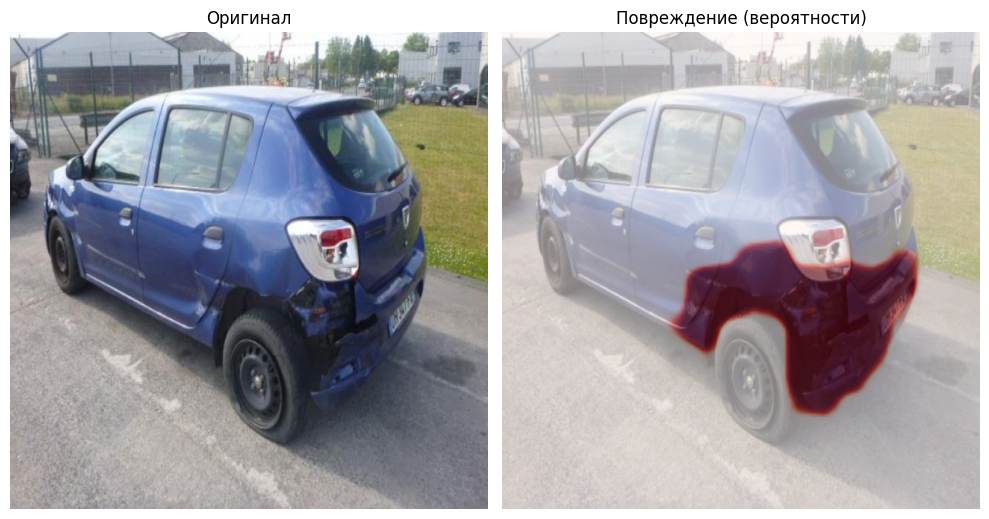

In [ ]:
image_path = "/Users/alexandr/Desktop/car-damage-detection-1/test/Car-damages-1237_png.rf.bd398b68b75580f7fa981df2beff6f99.jpg"
predict_and_visualize_image(image_path)

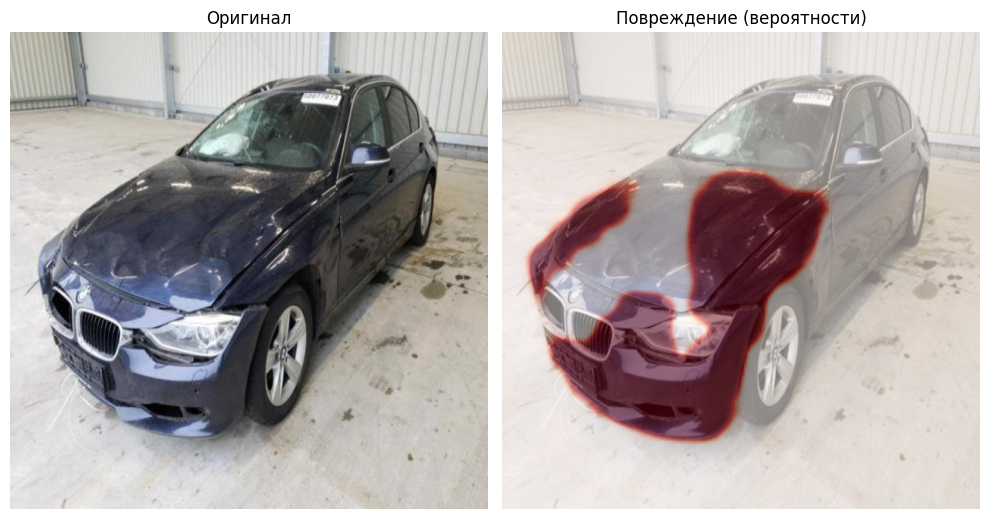

In [61]:
image_path = "/Users/alexandr/Desktop/car-damage-detection-1/test/Car-damages-909_png.rf.108fb881e95aeca95f69f200431b54ad.jpg"
predict_and_visualize_image(image_path)

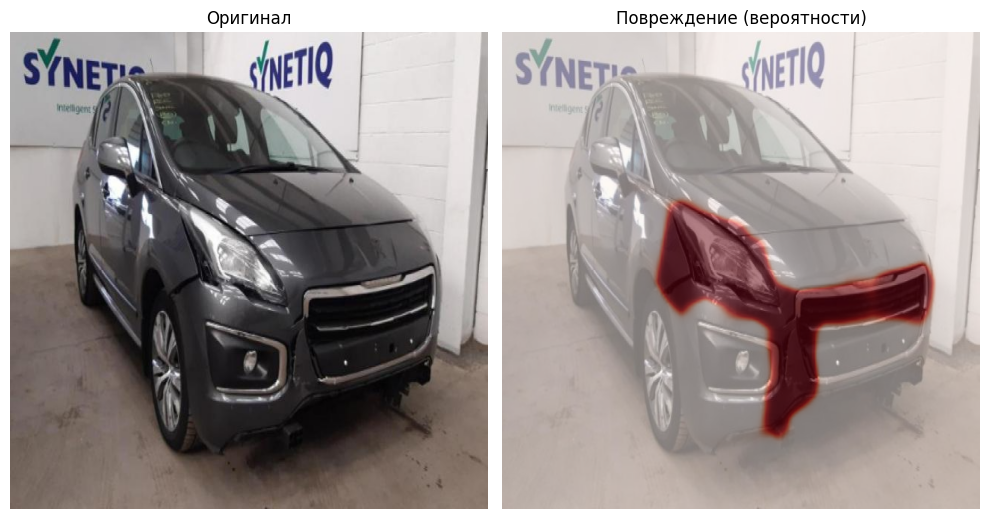

In [62]:
image_path = "/Users/alexandr/Desktop/car-damage-detection-1/test/Car-damages-981_png.rf.ed23454dddd522241dbae3e7557bdb3c.jpg"
predict_and_visualize_image(image_path)

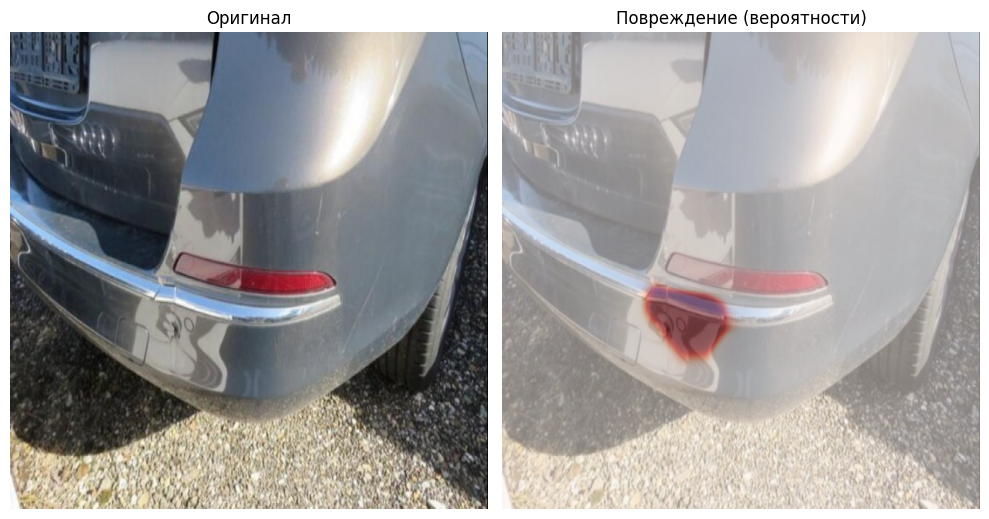

In [63]:
image_path = "/Users/alexandr/Desktop/car-damage-detection-1/test/Car-damages-1073_png.rf.f1ee945187c1476c01716a117370da2f.jpg"
predict_and_visualize_image(image_path)

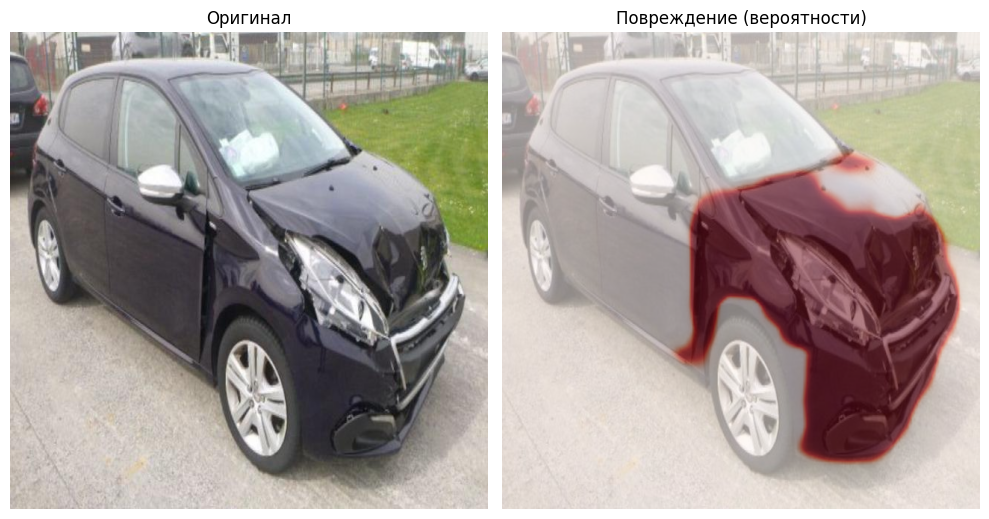

In [64]:
image_path = "/Users/alexandr/Desktop/car-damage-detection-1/test/Car-damages-1077_png.rf.28055779a8c5fabd1363e8e63f638da4.jpg"
predict_and_visualize_image(image_path)

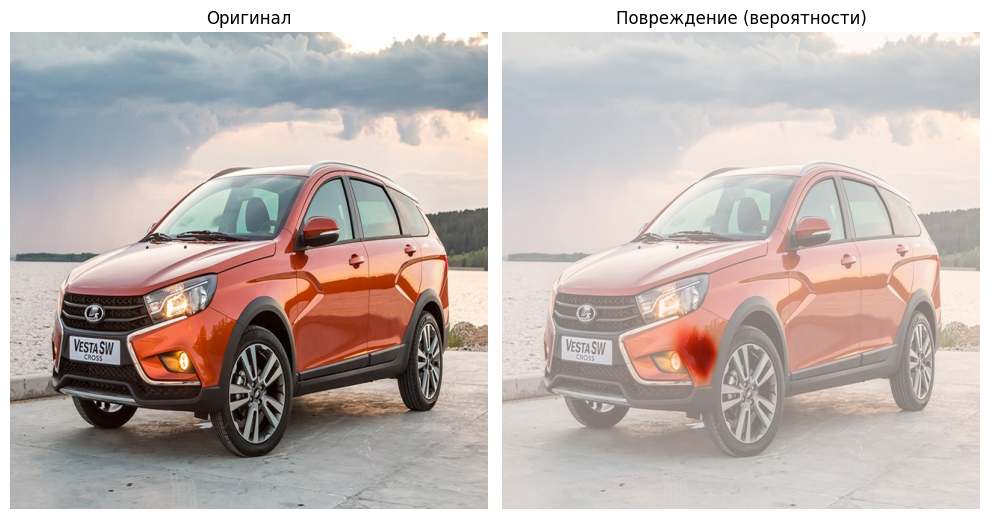

In [66]:
image_path = "/Users/alexandr/Downloads/lada_vesta_sw_cross.jpeg"
predict_and_visualize_image(image_path)

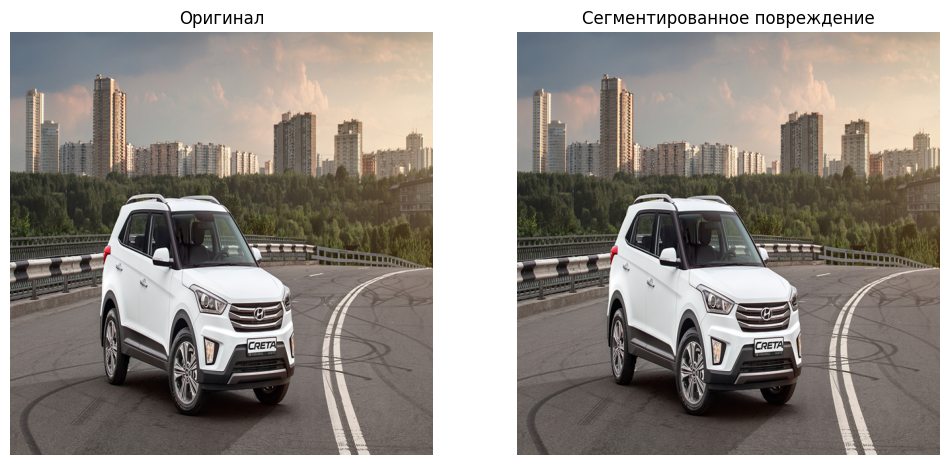

In [ ]:
image_path = "/Users/alexandr/Downloads/lada_vesta_sw_cross.jpeg"
predict_and_visualize_image(image_path)

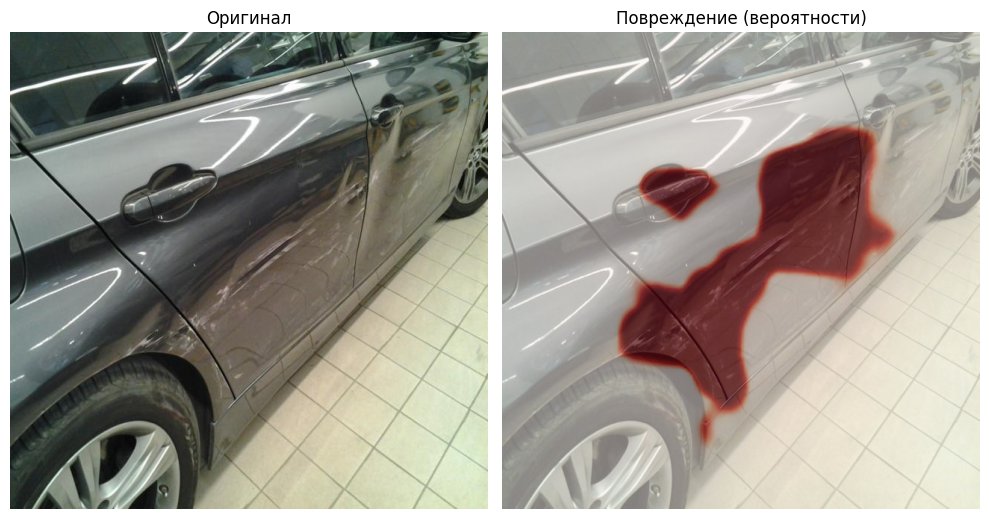

In [75]:
image_path = "/Users/alexandr/Downloads/car_damage_segm_dataset_5-2/test/0385146767_1728_jpg.rf.0e5fa024c7cab7ca1422f4b56f696203.jpg"
predict_and_visualize_image(image_path)

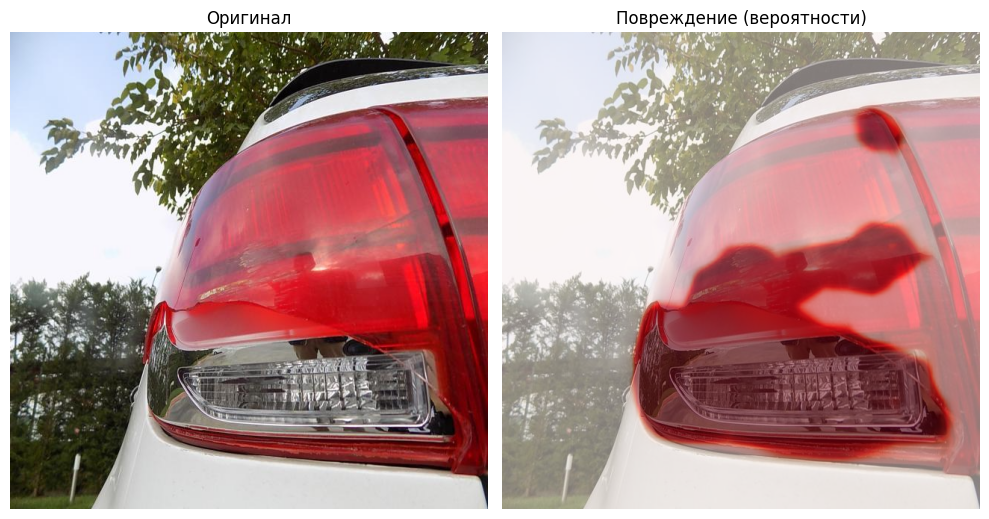

In [76]:
image_path = "/Users/alexandr/Downloads/car_damage_segm_dataset_5-2/test/0513164683_2677_jpg.rf.4901245dd110989210ebfe0ededcf62f.jpg"
predict_and_visualize_image(image_path)

В ходе визуального анализа предсказаний модели было установлено:
 - Mодель не переобучилась на синтетические данные и демонстрирует устойчивую способность выделять повреждения на реальных фотографиях автомобилей (лучше, чем обученные до этого SMP модели)
 - Вместе с тем, наблюдаются случаи избыточной сегментации, при которой к области повреждения ошибочно причисляются лишние пиксели — вероятно, это связано с использованием функции потерь Tversky Loss с параметрами, акцентирующими внимание модели на минимизацию пропусков
 - Также выявлено, что в отдельных ситуациях модель предсказывает наличие повреждений на целых автомобилях, чаще всего в зонах с резкими перепадами освещения (например, в тенях)
 - Если на вход модели подавать изображения, где машина изображена не целиком, а крупно изображена какая-нибудь ее часть модель справляется хорошо

Итоговые метрики лучшей модели:
 - Damage Iou - 0.579541
 - Background IoU - 0.961838
 - Mean IoU - 0.770690
 - Accuracy - 0.963745